<a href="https://www.kaggle.com/code/rishitjakharia/isruc-eda-modelling?scriptVersionId=214556364" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing

In [ ]:
import os
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt

#### Setting Seed for reproducability

In [ ]:
import random
import os

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

# Initial Graphs for class imbalance
----

```python
event_count = 0

for foldername, subfolders, filenames in os.walk('/kaggle/input/isruc-processed/dataset/Events'):
    if foldername.split('/')[-1] == 'Events':
        continue
    event_count += len(filenames)
    print(f"Event: '{foldername.split('/')[-1]}' has {len(filenames)} files.")


for foldername, subfolders, filenames in os.walk('/kaggle/input/isruc-processed/dataset/Non_Events'):
    if foldername.split('/')[-1] == 'Events':
        continue
    event_count += len(filenames)
    print(f"Event: '{foldername.split('/')[-1]}' has {len(filenames)} files.")

print(f"Total Event count: {event_count}")
```

Now, to maintain class balance when learning a sleep stage classifier and to have sufficient amount of non-event examples we shall sample the sum of all these.

Also, we are only looking at the cases where both Experts classify the event as a non-event.

In [ ]:
files = {
    'l on': 141,
    'ar': 25544,
    'mchg': 1530,
    'ch': 159,
    'l out': 218,
    'plm': 3402,
    'rem': 213,
    'awake': 4666,
    'oa': 1374,
    'ca': 362,
    'oh': 3652,
    'mh': 2707,
    'lm': 823,
    'non-events': 33531
}

# Prepare data for plotting
categories = list(files.keys())
values = list(files.values())

# Convert data to a DataFrame for seaborn
data = pd.DataFrame({
    'Category': categories,
    'Value': values
})

# Add a hue column for demonstration (e.g., splitting events into "Events" and "Non-events")
data['Type'] = ['Event' if cat != 'non-events' else 'Non-event' for cat in categories]

# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Category', y='Value', hue='Type', palette='coolwarm')
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Distribution of Event Data with Hue', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There seems to be severe class imbalance, looking at the relevant labels now

In [ ]:
files = {
    'oa': 1374,
    'ca': 362,
    'oh': 3652,
    'mh': 2707,
    'ch': 159
}

# Prepare data for plotting
categories = list(files.keys())
values = list(files.values())

# Convert data to a DataFrame for seaborn
data = pd.DataFrame({
    'Category': categories,
    'Value': values
})

# Add a hue column for demonstration (e.g., splitting events into "Events" and "Non-events")
data['Type'] = ['Event' if cat != 'non-events' else 'Non-event' for cat in categories]

# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Category', y='Value', hue='Type', palette='YlGnBu')
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Distribution of Event Data with Hue', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Loading Data
----

## Sleep Stage Dataset

In [ ]:
class Normalization(object):
    def __init__(self, method="z-score", axis=1, epsilon=1e-8):
        """
        Args:
            method (str): Normalization method ('z-score' or 'min-max').
            axis (int): Axis along which to normalize (0: samples, 1: channels).
            epsilon (float): Small constant to avoid division by zero.
        """
        self.method = method
        self.axis = axis
        self.epsilon = epsilon

    def __call__(self, signal):
        """
        Apply normalization to the signal.

        Args:
            signal (torch.Tensor): Signal tensor of shape (n_channels, n_samples).
        
        Returns:
            torch.Tensor: Normalized signal tensor of the same shape.
        """
        signal_np = signal.numpy() if isinstance(signal, torch.Tensor) else signal

        if self.method == "z-score":
            mean = np.mean(signal_np, axis=self.axis, keepdims=True)
            std = np.std(signal_np, axis=self.axis, keepdims=True) + self.epsilon
            normalized_signal = (signal_np - mean) / std
        elif self.method == "min-max":
            min_val = np.min(signal_np, axis=self.axis, keepdims=True)
            max_val = np.max(signal_np, axis=self.axis, keepdims=True) + self.epsilon
            normalized_signal = (signal_np - min_val) / (max_val - min_val)
        else:
            raise ValueError("Unsupported normalization method. Choose 'z-score' or 'min-max'.")

        return torch.tensor(normalized_signal, dtype=torch.float32)

class BandpassFilter(object):
    def __init__(self, lowcut, highcut, fs, order=4, padding_value=0):
        """
        Args:
            lowcut (float): Low frequency cutoff (Hz).
            highcut (float): High frequency cutoff (Hz).
            fs (float): Sampling frequency (Hz).
            order (int): Order of the filter.
            padding_value (float): Value to use for padding short signals.
        """
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.order = order
        self.padding_value = padding_value
        
        # Design the filter
        nyquist = 0.5*fs
        self.b, self.a = butter(self.order, [self.lowcut/nyquist, self.highcut/nyquist], btype='band')

    def __call__(self, signal):
        """
        Apply the bandpass filter to each channel in the signal.

        Args:
            signal (tensor): Signal tensor of shape (n_channels, n_samples).
        
        Returns:
            tensor: Filtered signal tensor of the same shape.
        """
        filtered_signal = []
        
        # Apply the filter to each channel
        for i in range(signal.shape[1]):  # Iterate over channels
            channel_signal = signal[:, i]
            
            # Pad the signal if it's too short
            if len(channel_signal) <= self.order:
                padding_length = self.order - len(channel_signal) + 1
                channel_signal = np.pad(channel_signal, (padding_length, padding_length), mode='constant', constant_values=self.padding_value)
            
            # Apply the filter to the padded signal
            filtered_signal.append(filtfilt(self.b, self.a, channel_signal))

        # Convert back to tensor
        return torch.tensor(np.array(filtered_signal), dtype=torch.float32)

In [ ]:
class SleepStageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing all folders and signal files.
            transform (callable, optional): Optional transform to apply to the signals.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data_info = self._prepare_file_list()

    def _prepare_file_list(self):
        """Scan the dataset directory and prepare a list of file paths and labels."""
        data_info = []
        for event_type in ['Events', 'Non_Events']:
            folder_path = os.path.join(self.root_dir, event_type)
            if os.path.isdir(folder_path):
                for subfolder_name in os.listdir(folder_path):
                    subfolder_path = os.path.join(folder_path, subfolder_name)
                    if os.path.isdir(subfolder_path):
                        for file_name in os.listdir(subfolder_path):
                            # Full file path
                            file_path = os.path.join(subfolder_path, file_name)
                            # Extraxt sleep stage label from filename
                            label = file_name.split('_')[3].replace('Stage', '')
                            
                            # Ignore errorneous labels
                            if label not in ['w', 'n1', 'n2', 'n3', 'r']:
                                continue
                            
                            data_info.append((file_path, label))
                            
        return data_info

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get file path and label
        file_path, label = self.data_info[idx]

        # converting label to one-hot
        label_to_one_hot = {
            'w':  [1,0,0,0,0],
            'n1': [0,1,0,0,0],
            'n2': [0,0,1,0,0],
            'n3': [0,0,0,1,0],
            'r':  [0,0,0,0,1],
        }
        label = label_to_one_hot[label]

        possible_columns = [
        ['X6', 'X7', 'X8', 'SaO2'],
        ['X6', 'X7', 'X8', 'SpO2'],
        ['29', '30', '31', 'SaO2'],
        ['29', '30', '31', 'SpO2']
        ]
        
        # Load signal data from .npy file
        signal = pd.read_csv(file_path)

        for columns in possible_columns:
            if all(col in signal.columns for col in columns):
                signal = signal[columns]
                break

        signal = torch.tensor(signal.values, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            for transform in self.transform:
                signal = transform(signal)

        return signal.T, label

In [ ]:
root_dir = '/kaggle/input/isruc-processed/dataset'
transform = [BandpassFilter(lowcut=0.2, highcut=0.5, fs=12.5), Normalization(method="z-score", axis=1)]

sleep_stage_dataset = SleepStageDataset(root_dir=root_dir, transform=transform)
sleep_stage_loader = DataLoader(sleep_stage_dataset, batch_size=1, shuffle=False)

count = 5
for signals, labels in sleep_stage_loader:
    print(signals.shape)
    print(labels)
    if count == 0:
        break
    count -= 1

## Events classification dataset

In [ ]:
class EventClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None, label_mapping=None, included_classes=None):
        """
        Args:
            root_dir (str): Root directory containing all folders and signal files.
            transform (callable, optional): Optional transform to apply to the signals.
            included_classes (list, optional): List of classes to include. If None, include all classes.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.included_classes = included_classes
        self.label_mapping = label_mapping
        self.data_info = self._prepare_file_list()

    def _prepare_file_list(self):
        """Scan the dataset directory and prepare a list of file paths and labels."""
        data_info = []

        # Process Event files
        # upper_limit_per_event = {
        #     'oa': 150,
        #     'ca': 150,
        #     'oh': 150,
        #     'mh': 150,
        #     'ch': 150
        # }
        
        # current_count = {
        #     'oa': 0,
        #     'ca': 0,
        #     'oh': 0,
        #     'mh': 0,
        #     'ch': 0
        # }
        # upper_limit_to_no_events = 300
        
        event_path = os.path.join(self.root_dir, 'Events')
        if os.path.isdir(event_path):
            for label_folder in os.listdir(event_path):
                if self.included_classes and label_folder not in self.included_classes:
                    continue

                label_path = os.path.join(event_path, label_folder)
                if os.path.isdir(label_path):
                    for file_name in os.listdir(label_path):
                        # Full file path
                        file_path = os.path.join(label_path, file_name)

                        # Append (file_path, label) tuple
                        if upper_limit_per_event[label_folder] != -1 and current_count[label_folder] == upper_limit_per_event[label_folder]:
                            continue
                        else:
                            current_count[label_folder] += 1
                        
                        data_info.append((file_path, label_folder))

        # Process Non Event files
        non_event_path = os.path.join(self.root_dir, 'Non_Events')
        if os.path.isdir(non_event_path):
            for subfolder_name in os.listdir(non_event_path):
                subfolder_path = os.path.join(non_event_path, subfolder_name)
                if os.path.isdir(subfolder_path):
                    for file_name in os.listdir(subfolder_path):
                        # Full file path
                        file_path = os.path.join(subfolder_path, file_name)

                        # Label for non-events is "no_event"
                        if not self.included_classes or 'no_event' in self.included_classes:
                            data_info.append((file_path, 'no_event'))

                        if upper_limit_to_no_events == 0:
                            break
                        upper_limit_to_no_events -= 1

        return data_info

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get file path and label
        file_path, label = self.data_info[idx]

        # Convert label to one-hot encoding
        unique_labels = self.included_classes if self.included_classes else ['ar', 'awake', 'ca', 'ch', 'l on', 'l out', 
                                                                             'lm', 'mchg', 'mh', 'oa', 'oh', 'plm', 'rem', 
                                                                             'no_event']
        label_to_one_hot = {label: [1 if i == idx else 0 for i in range(len(unique_labels))] 
                            for idx, label in enumerate(unique_labels)}
        label = label_to_one_hot[label]

        possible_columns = [
        ['X6', 'X7', 'X8', 'SaO2'],
        ['X6', 'X7', 'X8', 'SpO2'],
        ['29', '30', '31', 'SaO2'],
        ['29', '30', '31', 'SpO2']
        ]
        
        signal = pd.read_csv(file_path)
    
        for columns in possible_columns:
            if all(col in signal.columns for col in columns):
                signal = signal[columns]
                break
        
        signal = torch.tensor(signal.values, dtype=torch.float32)
        if self.label_mapping:
            label = self.label_mapping[np.argmax(label)]
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            for transform in self.transform:
                signal = transform(signal)

        return signal.T, label

In [ ]:
root_dir = '/kaggle/input/isruc-processed/dataset'
included_classes = ['ca', 'oa', 'oh', 'mh', 'ch', 'no_event']
transform = [BandpassFilter(lowcut=0.2, highcut=0.5, fs=12.5), Normalization(method='z-score', axis=1)]

event_classification_dataset = EventClassificationDataset(root_dir=root_dir, transform=transform, included_classes=included_classes)
event_classification_loader = DataLoader(event_classification_dataset, batch_size=1, shuffle=True)

count = 3
for signals, labels in event_classification_loader:
    print(included_classes[np.argmax(labels)])
    print('-'*100)
    if count == 0:
        break
    count -= 1

# Modelling
----

## Loss Function

In [ ]:
def kl_divergence_loss(preds, targets):
    targets = targets.float()
    
    preds = F.softmax(preds, dim=-1)
    targets = F.softmax(targets, dim=-1)
    loss = F.kl_div(preds.log(), targets, reduction='batchmean')
    return loss

def mse_loss(preds, targets):
    # Ensure that the predictions and targets are one-hot encoded
    preds = F.softmax(preds, dim=-1)
    return F.mse_loss(preds, targets)

# Focal Loss
def focal_loss(preds, targets, alpha=0.25, gamma=2.0):
    """
    Focal Loss for multi-class classification.
    
    Arguments:
    preds -- the raw logits from the model (shape: [batch_size, num_classes])
    targets -- the true labels (shape: [batch_size])
    alpha -- balancing factor for class imbalances (default is 0.25)
    gamma -- focusing parameter (default is 2.0)
    
    Returns:
    loss -- the computed focal loss
    """
    # Apply softmax to get probabilities
    preds = F.softmax(preds, dim=-1)
    
    # Convert targets to one-hot encoding
    targets_one_hot = targets
    
    # Cross-entropy loss
    ce_loss = F.cross_entropy(preds, targets, reduction='none')
    
    # Get the predicted probability for the correct class
    pt = torch.exp(-ce_loss)
    
    # Compute focal loss
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    
    return focal_loss.mean()

## Optimizer and Learning Rate

In [ ]:
def warmup_lr(epoch, step_size, warmup_epochs=5, gamma=0.1):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    
    else:
        epoch_since_warmup = epoch - warmup_epochs
        return gamma ** (epoch_since_warmup // step_size)

WARMUP_EPOCHS = 14
GAMMA = 0.1
STEP_SIZE = 20

## Plotting Train and Test Acc and Loss

In [ ]:
# Plot history
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')

    plt.show()

## Confusion Matrix Function

In [ ]:
def plot_confusion_matrix(model, val_loader, class_names, device="cuda"):
    """
    Evaluates the model and plots a confusion matrix with a custom color map.

    Arguments:
    - model: Trained PyTorch model.
    - val_loader: DataLoader for validation dataset.
    - class_names: List of class names for the confusion matrix.
    - device: 'cuda' or 'cpu'.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Predicted classes
            
            # If labels are one-hot encoded, convert them to class indices
            if len(labels.shape) > 1 and labels.size(1) > 1:
                labels = torch.argmax(labels, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix with customization
    fig, ax = plt.subplots(figsize=(10, 8))  # Set larger figure size
    disp.plot(cmap="YlGnBu", ax=ax, colorbar=True)  # Use "cividis" colormap and add colorbar
    plt.title("Confusion Matrix", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.show()

## Training Function

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import LeaveOneOut
from collections import defaultdict


def train_model(
    model,
    train_loader,
    val_loader,
    criterion=None,
    optimizer=None,
    scheduler=None,
    epochs=20,
    device="cpu",
    early_stopping=False,
    patience=20,
    min_delta=1e-3,
    save_path="best_model.pth",
    verbose=True
):
    """
    Train a PyTorch model with optional early stopping and learning rate scheduling.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (callable, optional): Loss function. Default is F.mse_loss.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        scheduler (callable, optional): Learning rate scheduler.
        epochs (int, optional): Number of training epochs. Default is 20.
        device (str, optional): Device to train on ("cpu" or "cuda"). Default is "cpu".
        early_stopping (bool, optional): Whether to enable early stopping. Default is False.
        patience (int, optional): Patience for early stopping. Default is 20.
        min_delta (float, optional): Minimum delta for early stopping. Default is 1e-3.
        save_path (str, optional): Path to save the best model. Default is 'best_model.pth'.
        verbose (bool, optional): Whether to print training progress. Default is True.

    Returns:
        dict: History of training and validation loss and accuracy.
    """
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_loss = np.inf
    best_acc = -np.inf
    patience_counter = 0
    best_model_state = None

    if criterion is None:
        criterion = F.mse_loss

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training", unit="batch", disable=not verbose) as tepoch:
            for inputs, targets in tepoch:
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets.float())
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)
                train_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                if verbose:
                    tepoch.set_postfix(loss=loss.item())

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation", unit="batch", disable=not verbose) as vepoch:
                for inputs, targets in vepoch:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets.float())
                    val_loss += loss.item() * inputs.size(0)
                    val_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                    if verbose:
                        vepoch.set_postfix(loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if verbose:
            print(
                f"Epoch {epoch + 1}/{epochs} - "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

        # Save the best model
        if best_acc < val_acc - min_delta:
            best_loss = val_loss
            best_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
            if verbose:
                print(f"New best model found at epoch {epoch + 1} with val_loss: {val_loss:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if early_stopping and patience_counter >= patience:
            if verbose:
                print("Early stopping triggered!")
            break

    # Save the best model at the end of training
    if best_model_state is not None:
        torch.save(best_model_state, save_path)
        if verbose:
            print(f"Best model saved to {save_path} with val_loss: {best_loss:.4f} and val_acc: {best_acc:.4f}")

    return history

def train_with_loocv(
    model_class,
    model_params,
    dataset,
    batch_size,
    optimizer_class,
    optimizer_params,
    shuffle=True,
    criterion=None,
    scheduler_class=None,
    scheduler_params=None,
    epochs=20,
    device="cpu",
    early_stopping=False,
    patience=20,
    min_delta=1e-3,
    save_path="best_model.pth",
    verbose=True
):
    """
    Train a PyTorch model using Leave-One-Out Cross-Validation (LOOCV), grouped by patient-session.

    Args:
        model_class (torch.nn.Module): The model class to instantiate for each fold.
        model_params (dict): Parameters for the model initialization.
        dataset (Dataset): The dataset to perform LOOCV on.
        batch_size (int): The batch size for the train loader.
        optimizer_class (torch.optim.Optimizer): Optimizer class.
        optimizer_params (dict): Parameters to initialize the optimizer.
        shuffle (bool): Whether to shuffle the train dataset or not. Default is True.
        criterion (callable, optional): Loss function. Default is `mse_loss`.
        scheduler_class (callable, optional): Learning rate scheduler class. Default is None.
        scheduler_params (dict, optional): Parameters for the scheduler. Default is None.
        epochs (int, optional): Number of epochs for training. Default is 20.
        device (str, optional): Device to train on ("cpu" or "cuda"). Default is "cpu".
        early_stopping (bool, optional): Whether to enable early stopping. Default is False.
        patience (int, optional): Patience for early stopping. Default is 20.
        min_delta (float, optional): Minimum delta for early stopping. Default is 1e-3.
        save_path (str, optional): Path to save the best model for each fold. Default is 'best_model.pth'.
        verbose (bool, optional): Whether to print training progress. Default is True.

    Returns:
        list: A list of histories for each fold.
    """
    # Group data by patient-session based on filename
    patient_session_groups = defaultdict(list)

    for idx, (_, label) in enumerate(dataset.data_info):
        filename = dataset.data_info[idx][0]
        filename = filename.split("/")[-1]
        patient_session_key = "_".join(filename.split("_")[:2])  # e.g., "S1_p_1"
        patient_session_groups[patient_session_key].append(idx)

    # Prepare LOOCV splits based on patient-session groups
    group_keys = list(patient_session_groups.keys())
    loo = LeaveOneOut()
    histories = []

    for fold, (train_group_idx, val_group_idx) in enumerate(loo.split(group_keys)):
        if verbose:
            print(f"\nFold {fold + 1}/{len(group_keys)}")

        # Get train and validation indices from groups
        train_idx = [idx for group_idx in train_group_idx for idx in patient_session_groups[group_keys[group_idx]]]
        val_idx = [idx for group_idx in val_group_idx for idx in patient_session_groups[group_keys[group_idx]]]

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = model_class(**model_params).to(device)
        optimizer = optimizer_class(model.parameters(), **optimizer_params)
        scheduler = None
        if scheduler_class is not None:
            scheduler = scheduler_class(optimizer, **scheduler_params)
        
        # Train the model for the current fold
        history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            epochs=epochs,
            device=device,
            early_stopping=early_stopping,
            patience=patience,
            min_delta=min_delta,
            save_path=f"{save_path}_fold_{fold+1}.pth",
            verbose=verbose,
        )

        # Append history for this fold
        histories.append(history)

    return histories

## Models
----
### Bi-LSTM + Attention

In [ ]:
class AdaptiveRNN(nn.Module):
    def __init__(self, n_timesteps, n_features, n_outputs):
        super(AdaptiveRNN, self).__init__()

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=256,
            batch_first=True,
            bidirectional=True
        )
        self.batch_norm = nn.BatchNorm1d(256 * 2)
        self.batch_norm1 = nn.BatchNorm1d(128)

        # Attention mechanism
        self.attention_dense = nn.Linear(256 * 2, 1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, timesteps, 128*2)
        
        batch_size, n_timesteps, n_features = lstm_out.size()
        lstm_out = lstm_out.reshape(batch_size * n_timesteps, n_features)
        lstm_out = self.batch_norm(lstm_out)
        lstm_out = lstm_out.reshape(batch_size, n_timesteps, n_features)
        
        # Attention mechanism
        attention_scores = torch.sigmoid(self.attention_dense(lstm_out))  # (batch_size, timesteps, 1)
        attention_scores = lstm_out * attention_scores  # Weighted timesteps

        # Global average pooling
        pooled = attention_scores.mean(dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(pooled))
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [77]:
# Define the model parameters
n_timesteps = 30 * 12.5
n_features = 4
n_outputs = 3

# Create the model
model = AdaptiveRNN(n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
AdaptiveRNN                              --
├─LSTM: 1-1                              536,576
├─BatchNorm1d: 1-2                       1,024
├─BatchNorm1d: 1-3                       256
├─Linear: 1-4                            513
├─Linear: 1-5                            65,664
├─Linear: 1-6                            8,256
├─Linear: 1-7                            195
├─Dropout: 1-8                           --
Total params: 612,484
Trainable params: 612,484
Non-trainable params: 0

```python
LEARNING_RATE = 0.001
BATCH_SIZE = 16
T_MAX = 50
ETA_MIN = 1e-6
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_class = AdaptiveRNN
model_params = {"n_timesteps": 375, "n_features": 4, "n_outputs": 6}

# Call train_with_loocv
# history = train_with_loocv(
#     model_class=model_class,
#     model_params=model_params,
#     dataset=event_classification_dataset,
#     batch_size=BATCH_SIZE,
#     criterion=kl_divergence_loss,
#     optimizer_class=torch.optim.Adam,
#     optimizer_params={"lr": LEARNING_RATE},
#     scheduler_class=torch.optim.lr_scheduler.CosineAnnealingLR,
#     scheduler_params={"T_max": T_MAX, "eta_min": ETA_MIN},
#     epochs=EPOCHS,
#     device=DEVICE,
#     early_stopping=False,  # Set to True if you want early stopping
#     patience=20,  # Adjust patience if early stopping is enabled
#     verbose=True
# )
```

In [78]:
root_dir = '/kaggle/input/isruc-processed/dataset'
included_classes = ['ca', 'oa', 'oh', 'mh', 'ch', 'no_event']
transform = [BandpassFilter(lowcut=0.2, highcut=0.5, fs=12.5), Normalization(method='min-max', axis=1)]

# label_mapping = {
#     'ca': 'apnea',
#     'oa': 'apnea',
#     'ch': 'apnea',
#     'oh': 'hypopnea',
#     'mh': 'hypopnea',
#     'no_event': 'no_event'
# }

label_mapping = [[1,0,0], [1,0,0], 
                 [0,1,0], [0,1,0], [0,1,0],
                 [0,0,1]
                ]

# Create an instance of the SleepStageDataset
event_classification_dataset = EventClassificationDataset(root_dir=root_dir, transform=transform, label_mapping=label_mapping, included_classes=included_classes)

patient_session_groups = defaultdict(list)

for idx, (_, label) in enumerate(event_classification_dataset.data_info):
    filename = event_classification_dataset.data_info[idx][0]
    filename = filename.split("/")[-1]
    patient_session_key = "_".join(filename.split("_")[:2])  # e.g., "S1_p_1"
    patient_session_groups[patient_session_key].append(idx)

group_keys = list(patient_session_groups.keys())
train_group_keys, test_group_keys = train_test_split(
    group_keys, test_size=0.1, random_state=42
)

# Get train and test indices from groups
train_idx = [idx for key in train_group_keys for idx in patient_session_groups[key]]
test_idx = [idx for key in test_group_keys for idx in patient_session_groups[key]]

# Create train and test subsets
train_subset = torch.utils.data.Subset(event_classification_dataset, train_idx)
test_subset = torch.utils.data.Subset(event_classification_dataset, test_idx)

# Create data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_subset)}")
print(f"Number of testing samples: {len(test_subset)}")

Number of training samples: 891
Number of testing samples: 163


In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

history = train_model(
    model = model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=focal_loss,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=5,
    device=device,
    early_stopping=False,
    patience=20,
    min_delta=1e-3,
    save_path="best_model.pth",
    verbose=True
)

Epoch 1/5 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.49s/batch, loss=0.122]


Epoch 1/5 - Train Loss: 0.1206, Train Acc: 0.4231 - Val Loss: 0.1215, Val Acc: 0.4969
New best model found at epoch 1 with val_loss: 0.1215


Epoch 2/5 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.44s/batch, loss=0.121]


Epoch 2/5 - Train Loss: 0.1180, Train Acc: 0.4759 - Val Loss: 0.1210, Val Acc: 0.4969


Epoch 3/5 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.44s/batch, loss=0.12]


Epoch 3/5 - Train Loss: 0.1165, Train Acc: 0.5140 - Val Loss: 0.1204, Val Acc: 0.4969


Epoch 4/5 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.24s/batch, loss=0.12]


Epoch 4/5 - Train Loss: 0.1150, Train Acc: 0.5051 - Val Loss: 0.1196, Val Acc: 0.4969


Epoch 5/5 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.50s/batch, loss=0.119]

Epoch 5/5 - Train Loss: 0.1133, Train Acc: 0.5163 - Val Loss: 0.1190, Val Acc: 0.4969
Best model saved to best_model.pth with val_loss: 0.1215 and val_acc: 0.4969


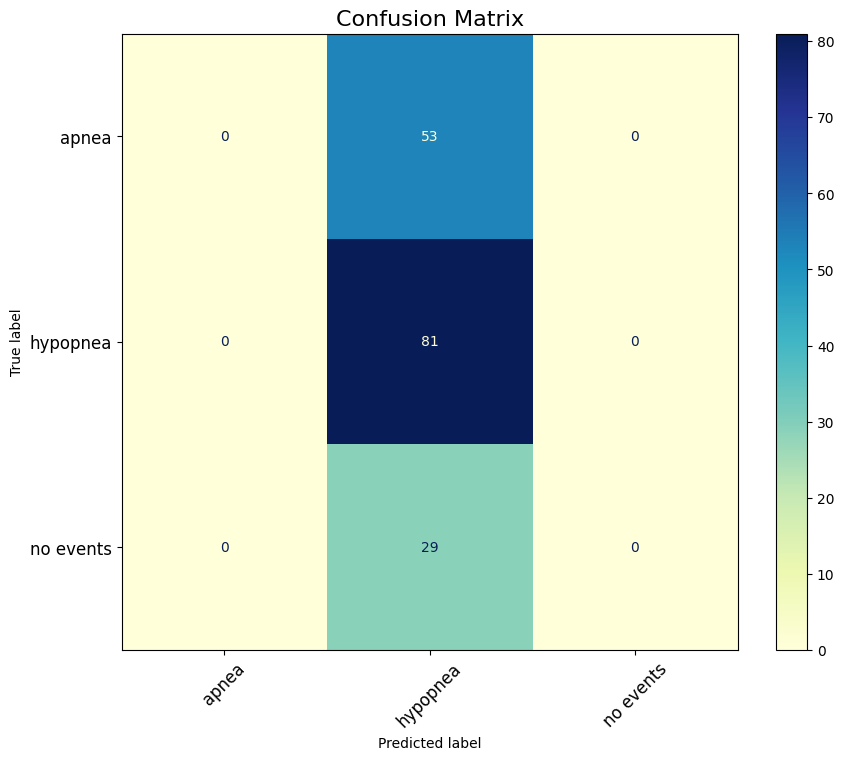

In [80]:
plot_confusion_matrix(model, test_loader, class_names=['apnea', 'hypopnea', 'no events'])

### Simple TCN

In [62]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate):
        super(TCNBlock, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding='same',
            dilation=dilation_rate
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)

        # Residual connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.batch_norm(out)

        shortcut = self.shortcut(x) if self.shortcut is not None else x
        return F.relu(out + shortcut)

class TCNModel(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNModel, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 128, kernel_size=3, dilation_rate=2),
            TCNBlock(128, 256, kernel_size=3, dilation_rate=4),
            TCNBlock(256, 64, kernel_size=3, dilation_rate=8)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [64]:
# Define the model parameters
n_timesteps = 30 * 12.5
n_features = 4
n_outputs = 3

# Create the model
model = TCNModel(n_length=n_timesteps, n_features=n_features, n_outputs=n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
TCNModel                                 --
├─Sequential: 1-1                        --
│    └─TCNBlock: 2-1                     --
│    │    └─Conv1d: 3-1                  832
│    │    └─BatchNorm1d: 3-2             128
│    │    └─Conv1d: 3-3                  320
│    └─TCNBlock: 2-2                     --
│    │    └─Conv1d: 3-4                  24,704
│    │    └─BatchNorm1d: 3-5             256
│    │    └─Conv1d: 3-6                  8,320
│    └─TCNBlock: 2-3                     --
│    │    └─Conv1d: 3-7                  98,560
│    │    └─BatchNorm1d: 3-8             512
│    │    └─Conv1d: 3-9                  33,024
│    └─TCNBlock: 2-4                     --
│    │    └─Conv1d: 3-10                 49,216
│    │    └─BatchNorm1d: 3-11            128
│    │    └─Conv1d: 3-12                 16,448
├─AdaptiveAvgPool1d: 1-2                 --
├─Linear: 1-3                            8,320
├─Linear: 1-4                          

In [70]:
root_dir = '/kaggle/input/isruc-processed/dataset'
included_classes = ['ca', 'oa', 'oh', 'mh', 'ch', 'no_event']
transform = [BandpassFilter(lowcut=0.2, highcut=0.5, fs=12.5), Normalization(method='z-score', axis=1)]

# label_mapping = {
#     'ca': 'apnea',
#     'oa': 'apnea',
#     'ch': 'apnea',
#     'oh': 'hypopnea',
#     'mh': 'hypopnea',
#     'no_event': 'no_event'
# }

label_mapping = [[1,0,0], [1,0,0], 
                 [0,1,0], [0,1,0], [0,1,0],
                 [0,0,1]
                ]

# Create an instance of the SleepStageDataset
event_classification_dataset = EventClassificationDataset(root_dir=root_dir, transform=transform, label_mapping=label_mapping, included_classes=included_classes)

patient_session_groups = defaultdict(list)

for idx, (_, label) in enumerate(event_classification_dataset.data_info):
    filename = event_classification_dataset.data_info[idx][0]
    filename = filename.split("/")[-1]
    patient_session_key = "_".join(filename.split("_")[:2])  # e.g., "S1_p_1"
    patient_session_groups[patient_session_key].append(idx)

group_keys = list(patient_session_groups.keys())
train_group_keys, test_group_keys = train_test_split(
    group_keys, test_size=0.1, random_state=42
)

# Get train and test indices from groups
train_idx = [idx for key in train_group_keys for idx in patient_session_groups[key]]
test_idx = [idx for key in test_group_keys for idx in patient_session_groups[key]]

# Create train and test subsets
train_subset = torch.utils.data.Subset(event_classification_dataset, train_idx)
test_subset = torch.utils.data.Subset(event_classification_dataset, test_idx)

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_subset)}")
print(f"Number of testing samples: {len(test_subset)}")

Number of training samples: 891
Number of testing samples: 163


In [73]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

history = train_model(
    model = model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=focal_loss,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=100,
    device=device,
    early_stopping=False,
    patience=20,
    min_delta=1e-3,
    save_path="best_model.pth",
    verbose=True
)

Epoch 1/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.65batch/s, loss=0.0773]


Epoch 1/100 - Train Loss: 0.1001, Train Acc: 0.6768 - Val Loss: 0.0932, Val Acc: 0.7546
New best model found at epoch 1 with val_loss: 0.0932


Epoch 2/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.42batch/s, loss=0.0951]


Epoch 2/100 - Train Loss: 0.0979, Train Acc: 0.7037 - Val Loss: 0.0914, Val Acc: 0.7914
New best model found at epoch 2 with val_loss: 0.0914


Epoch 3/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.81batch/s, loss=0.101] 


Epoch 3/100 - Train Loss: 0.0955, Train Acc: 0.7385 - Val Loss: 0.1003, Val Acc: 0.6748


Epoch 4/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.89batch/s, loss=0.0994]


Epoch 4/100 - Train Loss: 0.0963, Train Acc: 0.7160 - Val Loss: 0.0975, Val Acc: 0.7055


Epoch 5/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.55batch/s, loss=0.101] 


Epoch 5/100 - Train Loss: 0.0938, Train Acc: 0.7587 - Val Loss: 0.0937, Val Acc: 0.7485


Epoch 6/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.89batch/s, loss=0.0796]


Epoch 6/100 - Train Loss: 0.0946, Train Acc: 0.7475 - Val Loss: 0.0951, Val Acc: 0.7423


Epoch 7/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.97batch/s, loss=0.096] 


Epoch 7/100 - Train Loss: 0.0928, Train Acc: 0.7654 - Val Loss: 0.0926, Val Acc: 0.7730


Epoch 8/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.97batch/s, loss=0.0753]


Epoch 8/100 - Train Loss: 0.0938, Train Acc: 0.7520 - Val Loss: 0.0981, Val Acc: 0.6994


Epoch 9/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.88batch/s, loss=0.0797]


Epoch 9/100 - Train Loss: 0.0911, Train Acc: 0.7946 - Val Loss: 0.0910, Val Acc: 0.7853


Epoch 10/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.87batch/s, loss=0.0995]


Epoch 10/100 - Train Loss: 0.0911, Train Acc: 0.7890 - Val Loss: 0.0940, Val Acc: 0.7485


Epoch 11/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.81batch/s, loss=0.0986]


Epoch 11/100 - Train Loss: 0.0903, Train Acc: 0.7980 - Val Loss: 0.0941, Val Acc: 0.7607


Epoch 12/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.68batch/s, loss=0.076] 


Epoch 12/100 - Train Loss: 0.0878, Train Acc: 0.8260 - Val Loss: 0.0925, Val Acc: 0.7669


Epoch 13/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.92batch/s, loss=0.0738]


Epoch 13/100 - Train Loss: 0.0870, Train Acc: 0.8429 - Val Loss: 0.0939, Val Acc: 0.7485


Epoch 14/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.71batch/s, loss=0.101] 


Epoch 14/100 - Train Loss: 0.0867, Train Acc: 0.8462 - Val Loss: 0.0953, Val Acc: 0.7239


Epoch 15/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.67batch/s, loss=0.0885]


Epoch 15/100 - Train Loss: 0.0865, Train Acc: 0.8440 - Val Loss: 0.0929, Val Acc: 0.7546


Epoch 16/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.56batch/s, loss=0.0761]


Epoch 16/100 - Train Loss: 0.0864, Train Acc: 0.8429 - Val Loss: 0.0946, Val Acc: 0.7362


Epoch 17/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.76batch/s, loss=0.0902]


Epoch 17/100 - Train Loss: 0.0857, Train Acc: 0.8563 - Val Loss: 0.0941, Val Acc: 0.7362


Epoch 18/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.87batch/s, loss=0.095] 


Epoch 18/100 - Train Loss: 0.0852, Train Acc: 0.8631 - Val Loss: 0.0936, Val Acc: 0.7485


Epoch 19/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.93batch/s, loss=0.0776]


Epoch 19/100 - Train Loss: 0.0851, Train Acc: 0.8642 - Val Loss: 0.0946, Val Acc: 0.7423


Epoch 20/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.93batch/s, loss=0.0904]


Epoch 20/100 - Train Loss: 0.0841, Train Acc: 0.8743 - Val Loss: 0.0974, Val Acc: 0.6994


Epoch 21/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.79batch/s, loss=0.0937]


Epoch 21/100 - Train Loss: 0.0835, Train Acc: 0.8810 - Val Loss: 0.0948, Val Acc: 0.7423


Epoch 22/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.71batch/s, loss=0.099] 


Epoch 22/100 - Train Loss: 0.0828, Train Acc: 0.8934 - Val Loss: 0.0946, Val Acc: 0.7423


Epoch 23/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.83batch/s, loss=0.101] 


Epoch 23/100 - Train Loss: 0.0819, Train Acc: 0.9001 - Val Loss: 0.0931, Val Acc: 0.7607


Epoch 24/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.72batch/s, loss=0.0806]


Epoch 24/100 - Train Loss: 0.0816, Train Acc: 0.9068 - Val Loss: 0.0961, Val Acc: 0.7239


Epoch 25/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.69batch/s, loss=0.089] 


Epoch 25/100 - Train Loss: 0.0811, Train Acc: 0.9113 - Val Loss: 0.0932, Val Acc: 0.7546


Epoch 26/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.98batch/s, loss=0.101] 


Epoch 26/100 - Train Loss: 0.0817, Train Acc: 0.9068 - Val Loss: 0.0956, Val Acc: 0.7423


Epoch 27/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.79batch/s, loss=0.0737]


Epoch 27/100 - Train Loss: 0.0806, Train Acc: 0.9181 - Val Loss: 0.0931, Val Acc: 0.7669


Epoch 28/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.80batch/s, loss=0.0737]


Epoch 28/100 - Train Loss: 0.0800, Train Acc: 0.9237 - Val Loss: 0.0920, Val Acc: 0.7853


Epoch 29/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.98batch/s, loss=0.0739]


Epoch 29/100 - Train Loss: 0.0799, Train Acc: 0.9259 - Val Loss: 0.0939, Val Acc: 0.7607


Epoch 30/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.83batch/s, loss=0.0833]


Epoch 30/100 - Train Loss: 0.0801, Train Acc: 0.9248 - Val Loss: 0.0914, Val Acc: 0.7730


Epoch 31/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.08batch/s, loss=0.0737]


Epoch 31/100 - Train Loss: 0.0801, Train Acc: 0.9214 - Val Loss: 0.0921, Val Acc: 0.7669


Epoch 32/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.93batch/s, loss=0.0737]


Epoch 32/100 - Train Loss: 0.0797, Train Acc: 0.9259 - Val Loss: 0.0924, Val Acc: 0.7669


Epoch 33/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.81batch/s, loss=0.0738]


Epoch 33/100 - Train Loss: 0.0793, Train Acc: 0.9315 - Val Loss: 0.0925, Val Acc: 0.7669


Epoch 34/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.94batch/s, loss=0.0738]


Epoch 34/100 - Train Loss: 0.0794, Train Acc: 0.9315 - Val Loss: 0.0924, Val Acc: 0.7791


Epoch 35/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.63batch/s, loss=0.0737]


Epoch 35/100 - Train Loss: 0.0789, Train Acc: 0.9371 - Val Loss: 0.0946, Val Acc: 0.7423


Epoch 36/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.68batch/s, loss=0.0744]


Epoch 36/100 - Train Loss: 0.0786, Train Acc: 0.9416 - Val Loss: 0.0921, Val Acc: 0.7730


Epoch 37/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.87batch/s, loss=0.0741]


Epoch 37/100 - Train Loss: 0.0785, Train Acc: 0.9450 - Val Loss: 0.0911, Val Acc: 0.7730


Epoch 38/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.96batch/s, loss=0.0739]


Epoch 38/100 - Train Loss: 0.0782, Train Acc: 0.9450 - Val Loss: 0.0914, Val Acc: 0.7853


Epoch 39/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.83batch/s, loss=0.0737]


Epoch 39/100 - Train Loss: 0.0783, Train Acc: 0.9439 - Val Loss: 0.0922, Val Acc: 0.7607


Epoch 40/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.96batch/s, loss=0.0737]


Epoch 40/100 - Train Loss: 0.0782, Train Acc: 0.9450 - Val Loss: 0.0930, Val Acc: 0.7546


Epoch 41/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.99batch/s, loss=0.0737]


Epoch 41/100 - Train Loss: 0.0780, Train Acc: 0.9484 - Val Loss: 0.0938, Val Acc: 0.7485


Epoch 42/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.94batch/s, loss=0.0737]


Epoch 42/100 - Train Loss: 0.0781, Train Acc: 0.9473 - Val Loss: 0.0916, Val Acc: 0.7853


Epoch 43/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.95batch/s, loss=0.0737]


Epoch 43/100 - Train Loss: 0.0782, Train Acc: 0.9439 - Val Loss: 0.0928, Val Acc: 0.7669


Epoch 44/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.87batch/s, loss=0.0737]


Epoch 44/100 - Train Loss: 0.0780, Train Acc: 0.9484 - Val Loss: 0.0923, Val Acc: 0.7669


Epoch 45/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.94batch/s, loss=0.0738]


Epoch 45/100 - Train Loss: 0.0780, Train Acc: 0.9473 - Val Loss: 0.0912, Val Acc: 0.7853


Epoch 46/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.77batch/s, loss=0.0738]


Epoch 46/100 - Train Loss: 0.0779, Train Acc: 0.9484 - Val Loss: 0.0922, Val Acc: 0.7730


Epoch 47/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.47batch/s, loss=0.0737]


Epoch 47/100 - Train Loss: 0.0780, Train Acc: 0.9484 - Val Loss: 0.0932, Val Acc: 0.7546


Epoch 48/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.88batch/s, loss=0.0737]


Epoch 48/100 - Train Loss: 0.0779, Train Acc: 0.9495 - Val Loss: 0.0932, Val Acc: 0.7546


Epoch 49/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.70batch/s, loss=0.0737]


Epoch 49/100 - Train Loss: 0.0781, Train Acc: 0.9473 - Val Loss: 0.0933, Val Acc: 0.7485


Epoch 50/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.89batch/s, loss=0.0738]


Epoch 50/100 - Train Loss: 0.0781, Train Acc: 0.9484 - Val Loss: 0.0919, Val Acc: 0.7730


Epoch 51/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.96batch/s, loss=0.0738]


Epoch 51/100 - Train Loss: 0.0780, Train Acc: 0.9473 - Val Loss: 0.0920, Val Acc: 0.7669


Epoch 52/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.06batch/s, loss=0.0737]


Epoch 52/100 - Train Loss: 0.0781, Train Acc: 0.9473 - Val Loss: 0.0927, Val Acc: 0.7607


Epoch 53/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.91batch/s, loss=0.0737]


Epoch 53/100 - Train Loss: 0.0778, Train Acc: 0.9495 - Val Loss: 0.0927, Val Acc: 0.7669


Epoch 54/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.92batch/s, loss=0.0737]


Epoch 54/100 - Train Loss: 0.0780, Train Acc: 0.9484 - Val Loss: 0.0924, Val Acc: 0.7607


Epoch 55/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.96batch/s, loss=0.0737]


Epoch 55/100 - Train Loss: 0.0778, Train Acc: 0.9495 - Val Loss: 0.0928, Val Acc: 0.7546


Epoch 56/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.83batch/s, loss=0.0739]


Epoch 56/100 - Train Loss: 0.0779, Train Acc: 0.9495 - Val Loss: 0.0916, Val Acc: 0.7730


Epoch 57/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.85batch/s, loss=0.074] 


Epoch 57/100 - Train Loss: 0.0779, Train Acc: 0.9495 - Val Loss: 0.0916, Val Acc: 0.7791


Epoch 58/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.01batch/s, loss=0.0738]


Epoch 58/100 - Train Loss: 0.0780, Train Acc: 0.9484 - Val Loss: 0.0927, Val Acc: 0.7607


Epoch 59/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.95batch/s, loss=0.0737]


Epoch 59/100 - Train Loss: 0.0781, Train Acc: 0.9461 - Val Loss: 0.0918, Val Acc: 0.7730


Epoch 60/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.90batch/s, loss=0.0737]


Epoch 60/100 - Train Loss: 0.0781, Train Acc: 0.9461 - Val Loss: 0.0917, Val Acc: 0.7730


Epoch 61/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.91batch/s, loss=0.0738]


Epoch 61/100 - Train Loss: 0.0780, Train Acc: 0.9484 - Val Loss: 0.0911, Val Acc: 0.7791


Epoch 62/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.67batch/s, loss=0.0738]


Epoch 62/100 - Train Loss: 0.0782, Train Acc: 0.9450 - Val Loss: 0.0926, Val Acc: 0.7669


Epoch 63/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.96batch/s, loss=0.0755]


Epoch 63/100 - Train Loss: 0.0781, Train Acc: 0.9461 - Val Loss: 0.0905, Val Acc: 0.7975
New best model found at epoch 63 with val_loss: 0.0905


Epoch 64/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.91batch/s, loss=0.074] 


Epoch 64/100 - Train Loss: 0.0782, Train Acc: 0.9450 - Val Loss: 0.0908, Val Acc: 0.7853


Epoch 65/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.96batch/s, loss=0.0737]


Epoch 65/100 - Train Loss: 0.0778, Train Acc: 0.9495 - Val Loss: 0.0921, Val Acc: 0.7669


Epoch 66/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.68batch/s, loss=0.074] 


Epoch 66/100 - Train Loss: 0.0780, Train Acc: 0.9461 - Val Loss: 0.0918, Val Acc: 0.7669


Epoch 67/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.74batch/s, loss=0.0756]


Epoch 67/100 - Train Loss: 0.0783, Train Acc: 0.9428 - Val Loss: 0.0922, Val Acc: 0.7730


Epoch 68/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.41batch/s, loss=0.079] 


Epoch 68/100 - Train Loss: 0.0783, Train Acc: 0.9428 - Val Loss: 0.0917, Val Acc: 0.7791


Epoch 69/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.59batch/s, loss=0.0737]


Epoch 69/100 - Train Loss: 0.0781, Train Acc: 0.9461 - Val Loss: 0.0938, Val Acc: 0.7485


Epoch 70/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.88batch/s, loss=0.0737]


Epoch 70/100 - Train Loss: 0.0784, Train Acc: 0.9428 - Val Loss: 0.0926, Val Acc: 0.7607


Epoch 71/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.76batch/s, loss=0.101] 


Epoch 71/100 - Train Loss: 0.0786, Train Acc: 0.9416 - Val Loss: 0.0915, Val Acc: 0.7853


Epoch 72/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.73batch/s, loss=0.0745]


Epoch 72/100 - Train Loss: 0.0791, Train Acc: 0.9338 - Val Loss: 0.0921, Val Acc: 0.7791


Epoch 73/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.92batch/s, loss=0.101] 


Epoch 73/100 - Train Loss: 0.0791, Train Acc: 0.9383 - Val Loss: 0.0943, Val Acc: 0.7362


Epoch 74/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.87batch/s, loss=0.0808]


Epoch 74/100 - Train Loss: 0.0789, Train Acc: 0.9371 - Val Loss: 0.0955, Val Acc: 0.7301


Epoch 75/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.88batch/s, loss=0.1]   


Epoch 75/100 - Train Loss: 0.0787, Train Acc: 0.9405 - Val Loss: 0.0926, Val Acc: 0.7669


Epoch 76/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.72batch/s, loss=0.106] 


Epoch 76/100 - Train Loss: 0.0825, Train Acc: 0.8934 - Val Loss: 0.0941, Val Acc: 0.7423


Epoch 77/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.60batch/s, loss=0.101] 


Epoch 77/100 - Train Loss: 0.0822, Train Acc: 0.8934 - Val Loss: 0.0932, Val Acc: 0.7546


Epoch 78/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.90batch/s, loss=0.0737]


Epoch 78/100 - Train Loss: 0.0825, Train Acc: 0.8923 - Val Loss: 0.0999, Val Acc: 0.6810


Epoch 79/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.73batch/s, loss=0.0992]


Epoch 79/100 - Train Loss: 0.0819, Train Acc: 0.9012 - Val Loss: 0.0917, Val Acc: 0.7730


Epoch 80/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.81batch/s, loss=0.0998]


Epoch 80/100 - Train Loss: 0.0818, Train Acc: 0.8979 - Val Loss: 0.0957, Val Acc: 0.7301


Epoch 81/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.82batch/s, loss=0.0777]


Epoch 81/100 - Train Loss: 0.0809, Train Acc: 0.9136 - Val Loss: 0.0948, Val Acc: 0.7423


Epoch 82/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.84batch/s, loss=0.101] 


Epoch 82/100 - Train Loss: 0.0836, Train Acc: 0.8799 - Val Loss: 0.0918, Val Acc: 0.7791


Epoch 83/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.65batch/s, loss=0.101] 


Epoch 83/100 - Train Loss: 0.0832, Train Acc: 0.8833 - Val Loss: 0.0932, Val Acc: 0.7607


Epoch 84/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.52batch/s, loss=0.101] 


Epoch 84/100 - Train Loss: 0.0824, Train Acc: 0.8923 - Val Loss: 0.0966, Val Acc: 0.7178


Epoch 85/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.21batch/s, loss=0.0963]


Epoch 85/100 - Train Loss: 0.0830, Train Acc: 0.8866 - Val Loss: 0.0965, Val Acc: 0.7055


Epoch 86/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.93batch/s, loss=0.074] 


Epoch 86/100 - Train Loss: 0.0806, Train Acc: 0.9169 - Val Loss: 0.0931, Val Acc: 0.7607


Epoch 87/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.80batch/s, loss=0.0737]


Epoch 87/100 - Train Loss: 0.0812, Train Acc: 0.9091 - Val Loss: 0.0918, Val Acc: 0.7791


Epoch 88/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.41batch/s, loss=0.0742]


Epoch 88/100 - Train Loss: 0.0845, Train Acc: 0.8653 - Val Loss: 0.0959, Val Acc: 0.7239


Epoch 89/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.40batch/s, loss=0.101] 


Epoch 89/100 - Train Loss: 0.0835, Train Acc: 0.8799 - Val Loss: 0.0951, Val Acc: 0.7362


Epoch 90/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.74batch/s, loss=0.101] 


Epoch 90/100 - Train Loss: 0.0879, Train Acc: 0.8272 - Val Loss: 0.0960, Val Acc: 0.7239


Epoch 91/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.79batch/s, loss=0.101] 


Epoch 91/100 - Train Loss: 0.0855, Train Acc: 0.8552 - Val Loss: 0.0943, Val Acc: 0.7423


Epoch 92/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.85batch/s, loss=0.101] 


Epoch 92/100 - Train Loss: 0.0820, Train Acc: 0.8979 - Val Loss: 0.0927, Val Acc: 0.7669


Epoch 93/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.66batch/s, loss=0.0736]


Epoch 93/100 - Train Loss: 0.0848, Train Acc: 0.8687 - Val Loss: 0.0983, Val Acc: 0.6994


Epoch 94/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.83batch/s, loss=0.0736]


Epoch 94/100 - Train Loss: 0.0836, Train Acc: 0.8788 - Val Loss: 0.0995, Val Acc: 0.6810


Epoch 95/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.87batch/s, loss=0.101] 


Epoch 95/100 - Train Loss: 0.0826, Train Acc: 0.8911 - Val Loss: 0.0914, Val Acc: 0.7791


Epoch 96/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.71batch/s, loss=0.101] 


Epoch 96/100 - Train Loss: 0.0815, Train Acc: 0.9046 - Val Loss: 0.0920, Val Acc: 0.7730


Epoch 97/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.81batch/s, loss=0.101] 


Epoch 97/100 - Train Loss: 0.0808, Train Acc: 0.9102 - Val Loss: 0.0953, Val Acc: 0.7239


Epoch 98/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.13batch/s, loss=0.101] 


Epoch 98/100 - Train Loss: 0.0835, Train Acc: 0.8799 - Val Loss: 0.0963, Val Acc: 0.7239


Epoch 99/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.70batch/s, loss=0.0739]


Epoch 99/100 - Train Loss: 0.0819, Train Acc: 0.8990 - Val Loss: 0.0938, Val Acc: 0.7485


Epoch 100/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.91batch/s, loss=0.0761]

Epoch 100/100 - Train Loss: 0.0811, Train Acc: 0.9057 - Val Loss: 0.0932, Val Acc: 0.7669
Best model saved to best_model.pth with val_loss: 0.0905 and val_acc: 0.7975


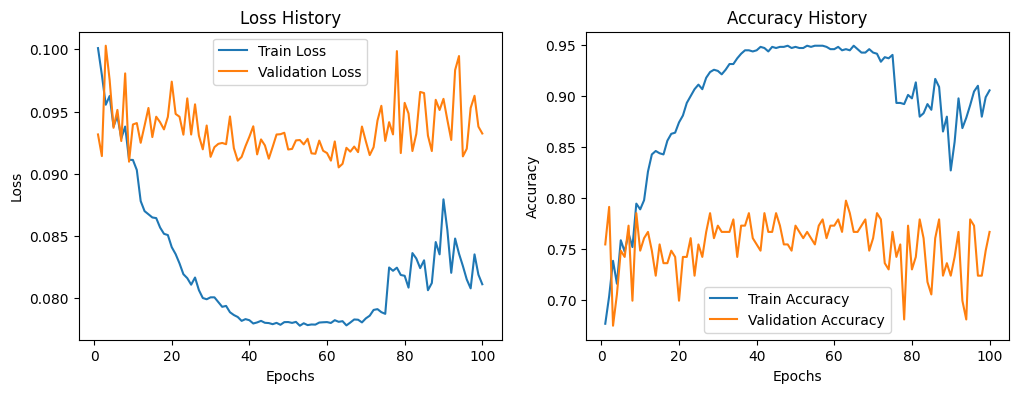

In [74]:
plot_history(history)

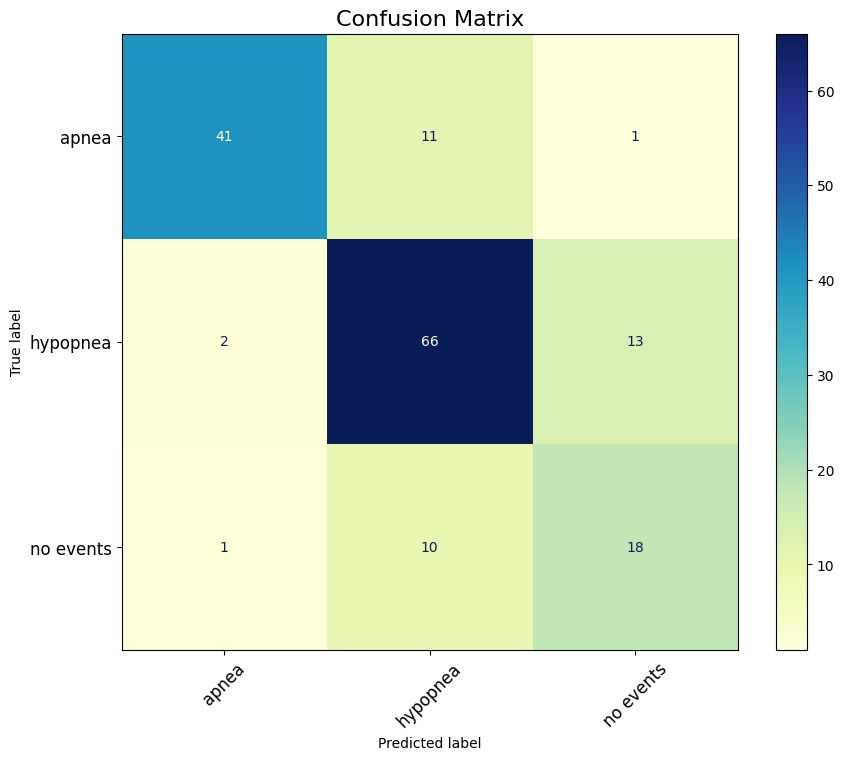

In [76]:
plot_confusion_matrix(model, test_loader, class_names=['apnea', 'hypopnea', 'no events'])